# Reconnaissance d'usages électriques par un Perceptron Multi-Couche (MLP)

## Modélisation du problème 

Le problème auquel nous sommes confrontés est un problème de classification. A partir des données de consommation de différents appareils électriques (réfrigerateur, chauffage électrique, ordinateur...) d'un client d'EDF, nous devons prédire la nature d'un appareil connaissant uniquement des données de consommation. 

Les données sont relevées pour 12 appareils différents, à intervalle de 30s, pendant une journée entière.Nous possédons des données pour 3 mois consécutifs. 

Nous allons utiliser un réseau de neurones pour traiter le problème. Le cas le plus simple est celui de la classification binaire, pour lequel le modèle du perceptron simple est adapté. Cependant, nous sommes confrontés à un problème plus complexe car il y a 12 classes (ou labels) à identifier, donc le perceptron simple n'est plus utilisable car le problème n'est pas linéairement séparable. Nous allons donc construire un perceptron multicouche, qui est plus adapté à notre problème. 

## Construction et entrainement du réseau 

### Importation des bibliothèques 

In [391]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt 

from sklearn.neural_network import MLPClassifier  #Permet de construire le perceptron multi-couches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

### Importation et traitement des données 

In [368]:
dutch_file = 'C:/Users/pihou/Desktop/EI_DS/Reconnaissance_Usages/dutch_30s_etude.pkl' 
dutch_data = pd.read_pickle(dutch_file)  #fichier contenant les données d'entrainement et de test
dutch_data.head()

,date_jour,usage,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2871,X_2872,X_2873,X_2874,X_2875,X_2876,X_2877,X_2878,X_2879,X_2880
0,2015-07-04,electric_heating_element,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5500,2.550000,2.550000,2.55,2.55,2.550000,2.550000,2.550000,2.550000,2.550000
2,2015-07-04,fridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.5624,97.027600,37.622500,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,2015-07-04,laptop_computer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0000,7.000000,7.000000,7.00,7.00,7.000000,7.607444,7.412410,7.193313,8.075000
4,2015-07-04,mains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,166.7100,167.073333,124.613333,68.76,69.51,69.156667,68.573333,69.636667,68.746667,69.283333
5,2015-07-04,microwave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2400,1.240000,1.240000,1.24,1.24,1.240000,1.240000,1.240000,1.240000,1.240000


In [369]:
# On importe le dataset qui contient les variables explicatives du réseau de neurones (dataset issu du traitement du tableau au-dessus)
dataset = pd.read_csv('C:/Users/pihou/Desktop/EI_DS/Reconnaissance_Usages/Var_Explicatives.csv')
dataset.head()
#Le dataset contient autant de lignes que le tableau précédent.

,Unnamed: 0,date_jour,usage,intégrale,valeur_moy,min,max,moy,ecart_type,mediane,kurtosis
0,0,2015-07-04,electric_heating_element,2.474058e+04,0.286349,0.0,66.962238,0.286349,2.181223,0.0,650.237333
1,2,2015-07-04,fridge,4.097024e+05,4.741926,0.0,131.235500,4.741926,21.213353,0.0,16.496680
2,3,2015-07-04,laptop_computer,1.277158e+05,1.478192,0.0,35.551765,1.478192,5.847689,0.0,17.183693
3,4,2015-07-04,mains,1.011197e+06,11.703670,0.0,241.186667,11.703670,41.558862,0.0,12.065517
4,5,2015-07-04,microwave,8.928000e+03,0.103333,0.0,1.240000,0.103333,0.342718,0.0,7.090909


Regardons maintenant la répartition des usages pour savoir si le dataset est équilibré:

In [370]:
dataset['usage'].value_counts()

microwave                   139
mains                       139
electric_heating_element    139
washing_machine             139
fridge                      137
sockets                     121
laptop_computer             114
fan                          83
cooker                       67
television                   62
toaster                      35
oven                         32
Name: usage, dtype: int64

On constate que le dataset est peu équilibré. Il y a par exemple très peu de valeurs pour l'usage "oven" et "toaster" alors qu'il y en a quasiment 5 fois plus pour "microwave". 

Cela pose problème pour l'entrainement du réseau de neurone. En effet, pour qu'il ne soit pas faussé, il faut dans l'idéal un dataset parfaitement équilibré, dans lequel il y a autant de valeurs pour chaque label. 

Quitte à réduire la taille du dataset, nous allons former un dataset assez équilibré dans lequel il y a aura environ 65 valeurs par label (on conserve le nombre initial de valeurs pour les labels avec moins de 65 valeurs). On constate que le dataset est peu équilibré. Il y a par exemple très peu de valeurs pour l'usage "oven" et "toaster" alors qu'il y en a quasiment 5 fois plus pour "microwave". 

Cela pose problème pour l'entrainement du réseau de neurone. En effet, pour qu'il ne soit pas faussé, il faut dans l'idéal un dataset parfaitement équilibré, dans lequel il y a autant de valeurs pour chaque label. 

Quitte à réduire la taille du dataset, nous allons former un dataset assez équilibré dans lequel il y a aura environ 65 valeurs par label (on conserve le nombre initial de valeurs pour les labels avec moins de 65 valeurs). 

In [147]:
#PAS UTILE, ALLER DIRECTEMENT A LA PARTIE 1.2.3 Construction et entrainement du réseau

# On commence par construire une liste de couples contenant en premier terme la liste des valeurs explicatives journalières pour un appareil, et le deuxième terme correspond au nom de l'appreil
L = [[0,0] for i in range(dataset.shape[0])]
dataset_list = dataset.values.tolist()   #On transforme le dataset en liste pour ne pas avoir de problèmes d'indices pour récupérer des lignes de la dataframe (certains indices sont manquants)
for i in range(0,len(dataset_list)):
    L[i][0] = dataset_list[i][3:]
    L[i][1] = dataset_list[i][2] 

# Maintenant, on réduit la taille de la liste en limitant à 65 le nombre de valeurs pour les labels en contenant plus. 
# En même temps, on formalise numériquement les labels en les représentant par des vecteurs valant 1 à l'indice de l'appareil et 0 sinon. 
L_balanced = []
a=0 #Ce sont les compteurs pour tous plus de 65 valeurs (on conservera en fait les 67 valeurs pour le cooker)
b=0 
c=0 
d=0 
e=0 
f=0 
g=0
h=0
for k in range(len(L)):
    if L[k][1] == 'microwave' and a<65:   #On met les labels qui contiennent le plus de valeurs au début pour réduire le nombre de tests effectués donc le temps de calcul
        #L_balanced.append([L[k][0],[1,0,0,0,0,0,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        a+=1        #On incrémente le compteur
    elif L[k][1] == 'mains' and b<65:
        #L_balanced.append([L[k][0],[0,1,0,0,0,0,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        b+=1
    elif L[k][1] == 'electric_heating_element' and c<65:
        #L_balanced.append([L[k][0],[0,0,1,0,0,0,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        c+=1
    elif L[k][1] == 'washing_machine' and d<65:
        #L_balanced.append([L[k][0],[0,0,0,1,0,0,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        d+=1
    elif L[k][1] == 'fridge' and e<65:
        #L_balanced.append([L[k][0],[0,0,0,0,1,0,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        e+=1
    elif L[k][1] == 'sockets' and f<65:
        #L_balanced.append([L[k][0],[0,0,0,0,0,1,0,0,0,0,0,0]])
        L_balanced.append(L[k])
        f+=1
    elif L[k][1] == 'laptop_computer' and g<65:
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,1,0,0,0,0,0]])
        L_balanced.append(L[k])
        g+=1
    elif L[k][1] == 'fan' and h<65:
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,0,1,0,0,0,0]])
        L_balanced.append(L[k])
        h+=1
    elif L[k][1] == 'cooker':
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,0,0,1,0,0,0]])
        L_balanced.append(L[k])
    elif L[k][1] == 'television':
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,0,0,0,1,0,0]])
        L_balanced.append(L[k])
    elif L[k][1] == 'toaster':
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,0,0,0,0,1,0]])
        L_balanced.append(L[k])
    elif L[k][1] == 'oven':
        #L_balanced.append([L[k][0],[0,0,0,0,0,0,0,0,0,0,0,1]])
        L_balanced.append(L[k])
print(len(L_balanced))


Maintenant que le dataset est plus équilibré, on va séparer le dataset en données d'apprentissage (train_X, train_Y) et en données de test (test_X, test_Y). 

On va prendre 70% pour l'entrainement, et 30% pour le test d'accuracy (métrique utilisée dans notre étude).

In [305]:
test_pct = 0.3 #Pourentage du test
test_size = int(len(L_balanced)*test_pct)

# Construction des données d'apprentissage et de test
train = L_balanced[:-test_size]   # On prend pour l'entrainement les 70% premières données
train_X = []
train_Y = []
for k in range(len(train)):
    train_X.append(train[k][0])
    train_Y.append(train[k][1])

test = L_balanced[-test_size:]    # On prend pour le test les 30% restant
test_X = []
test_Y = []
for k in range(len(test)):
    test_X.append(test[k][0])
    test_Y.append(test[k][1])
#train_X_reshaped = train_X.reshape(-1,1)
#train_Y_reshaped = train_Y.reshape(-1,1)
#test_X_reshaped = test_X.reshape(-1,1)
#test_Y_reshaped = test_Y.reshape(-1,1)

### Construction et entrainement du réseau 

La bilbiothèque scikit.learn permet d'automatiser de nombreuses étapes et la fonction MLPClassifier permet une construction simplifiée du réseau de neurones. 

Les paramètres précisés sont le nombre de couches du réseaux (hidden layers), le nombre d'epochs (nombre de fois que l'on passe le dataset à travers le réseau) la fonction d'activation, l'optimiseur choisi pour réliser la descente de gradient... 

In [403]:
X = dataset[['intégrale','valeur_moy','max','ecart_type','mediane','kurtosis']]
y = dataset['usage']


X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = MLPClassifier(hidden_layer_sizes=(40,80))

classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

# Affichons les 50 premières valeurs des prédictions:
print(y_pred[:50])

# Affichons l'accuracy du réseau (taux de bonnes prédictions)
print("L'accuracy du réseau de neurone est:", accuracy_score(y_test, y_pred))

['toaster' 'fridge' 'toaster' 'laptop_computer' 'washing_machine'
 'electric_heating_element' 'fan' 'fridge' 'television' 'fridge' 'sockets'
 'mains' 'microwave' 'fridge' 'television' 'television' 'laptop_computer'
 'washing_machine' 'microwave' 'mains' 'cooker' 'washing_machine'
 'microwave' 'mains' 'electric_heating_element' 'washing_machine'
 'washing_machine' 'electric_heating_element' 'laptop_computer'
 'laptop_computer' 'fridge' 'washing_machine' 'mains' 'washing_machine'
 'laptop_computer' 'washing_machine' 'cooker' 'fan' 'washing_machine'
 'microwave' 'laptop_computer' 'television' 'washing_machine' 'television'
 'mains' 'electric_heating_element' 'sockets' 'fridge' 'television'
 'cooker']
L'accuracy du réseau de neurone est: 0.8675496688741722


C:\Users\pihou\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Désormais, optimisons les hyperparamètres du réseau ainsi que la taille du réseau (nombre de couches cachées et nombre de neurones par couche). On teste parmi différentes tailles de réseaux, le type de fonction d'activation, l'optimiseur (solveur) qui réalise la rétropropagation et la descente de gradient et qui actualise les poids et biais. Le learning_rate correspond au pas lors de la descente de gradient. On peut choisir un learning rate constant ou variable, qui s'adapte à la fonction de coût. 

In [390]:
parameter_space = {
    'hidden_layer_sizes': [(80),(40,80),(40,80,120),(30,60,90,120), (16,32,64,128,256)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(classifier, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best parameters set
print('Les hyperparamètres optimaux sont:\n', clf.best_params_)

Les hyperparamètres optimaux sont:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16, 32, 64, 128, 256), 'learning_rate': 'constant', 'solver': 'adam'}


On peut donc maintenant choisir les hyperparamètres optimisés pour le classificateur: 

In [404]:
classifier = MLPClassifier(hidden_layer_sizes=(16,32,64,128,256), activation='relu', solver='adam')

classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

# Affichons les 50 premières valeurs des prédictions:
print(y_pred[:50])
#Affichons la nouvelle accuracy:
print("L'accuracy du réseau optimisé de neurone est:", accuracy_score(y_test, y_pred))

['toaster' 'fridge' 'toaster' 'sockets' 'washing_machine'
 'electric_heating_element' 'fan' 'fridge' 'television' 'fridge' 'sockets'
 'mains' 'microwave' 'fridge' 'television' 'television' 'laptop_computer'
 'washing_machine' 'microwave' 'mains' 'cooker' 'washing_machine'
 'microwave' 'mains' 'electric_heating_element' 'washing_machine'
 'washing_machine' 'electric_heating_element' 'laptop_computer'
 'laptop_computer' 'fridge' 'washing_machine' 'mains' 'washing_machine'
 'laptop_computer' 'washing_machine' 'cooker' 'fan' 'washing_machine'
 'microwave' 'laptop_computer' 'laptop_computer' 'washing_machine'
 'television' 'mains' 'electric_heating_element' 'sockets' 'fridge' 'fan'
 'cooker']
L'accuracy du réseau optimisé de neurone est: 0.9039735099337748


On constate donc que l'accuracy a bien augmenté. On atteint un taux supérieur à 90% de bonnes prédictions, ce qui est satisfaisant. 

## Test des performances 

### Calcul de l'accuracy

Le critère de performance est le taux de classifications correctes (VraisPositifs + VraisNégatifs)/(Positifs + Négatifs). Ce taux est aussi appelé "accuracy". 

In [405]:
#On utilise le module "accuracy_score" de la bibliothèque sklearn.metrics : 
print("L'accuracy du réseau de neurone est:", accuracy_score(y_test, y_pred))


L'accuracy du réseau de neurone est: 0.9039735099337748


### Visualisation des résultats 

On peut construire la matrice de confusion qui permet de mieux visualiser les prédictions. On utilise pour cela le module "confusion_matrix" de la bibliothèque sklearn.metrics:

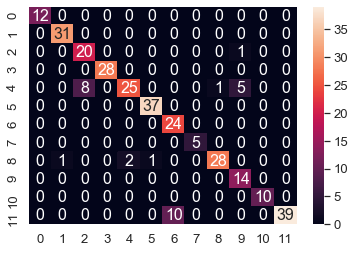

In [406]:
import seaborn as sn
cm = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cm, range(12), range(12))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

Les entrées à gauche du tableau sont les labels des prédictions et les entrées en bas sont les labels des tests (connus). Les valeurs de la diagonale correspondent donc aux bonnes prédictions.Très peu d'erreurs ont été commises mais on remarque cependatn qu'elles sont localisées spécifiquement pour certains usages. Par exemple, le label d'indice 6 a été prédit 10 fois comme le label d'indice 11. 

On peut retrouver l'accuracy en sommant tous les termes de la diagonale et en divisant par le nombre total de valeurs. 

## application sur les données à labéliser 

### Importation des données

In [408]:
#On importe le fichier à partir duquel on souhaite prévoir les usages. 
dutch_file_pred = 'C:/Users/pihou/Desktop/EI_DS/Reconnaissance_Usages/dutch_30s_a_predire_na.pkl'
dataset_pred = pd.read_pickle(dutch_file_pred)
dataset_pred.head()

,date_jour,usage,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2871,X_2872,X_2873,X_2874,X_2875,X_2876,X_2877,X_2878,X_2879,X_2880
0,2015-07-30,a_predire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-10-07,a_predire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-07-06,a_predire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-07-10,a_predire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-11-10,a_predire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Traitement des données 

In [23]:
#On forme le dataset des valeurs explicatives X1 et des valeurs à expliquer Y1. 
X1 = dataset_pred['']

# Faire un programme pour faire les prédictions pour chaque ligne. 
# Former une liste de listes contenant les consommations journalières pour chaque ligne. 
# Calculer les critères pour chaque conso et reformer une liste de liste du type X_val = [[x1_1,x2_1,x3_1,x4_1,x5_1,x6_1],...,[x1_n,x2_n,x3_n,x4_n,x5_n,x6_n]]
# Appliquer Y_pred = classifier.predict(X_val) qui renvoie [micro-onde, ordi, ordi,...] (ou passer par une boucle qui itère sur chaque élément de X_val si on peut pas appliquer predict à la liste directement)
# Modifier le dataset dataset_pred en changeant la colonne "usage" par la liste de valeurs prédites 
# Visualiser le fichier et le sauvegarder 

- On Applique le réseau sur la dataframe "inconnue" 
- Visualisation des résultats

## Bibliographie

[1] https://scikit-learn.org/stable/modules/neural_networks_supervised.html 

[2] https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/ (Pas la mettre celle-là) 

[3] https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

[4] http://scipy-lectures.org/packages/scikit-learn/ 

[5] http://eric.univ-lyon2.fr/~ricco/cours/slides/reseaux_neurones_perceptron.pdf